In [5]:
# Cell 1: Load Data and Initial Inspection

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# --- Configuration ---
# Define the relative path to your master dataset
# Assumes notebook is in 'BreatheEasy/notebook/' and data in 'BreatheEasy/data/...'
DATA_FILENAME = 'Master_AQI_Dataset.csv'
DATA_PATH = os.path.join('..', 'data', 'Post-Processing', 'CSV_Files', DATA_FILENAME)

# --- Load Data ---
print(f"Attempting to load data from: {DATA_PATH}")
if not os.path.exists(DATA_PATH):
    print(f"!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
    print(f"ERROR: File not found at the specified path: {DATA_PATH}")
    print(f"Please ensure '{DATA_FILENAME}' exists in the correct directory.")
    print(f"Current working directory is: {os.getcwd()}")
    print(f"!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
    raise FileNotFoundError(f"Could not find the data file at {DATA_PATH}")
else:
    print("Data file found. Loading...")
    try:
        # Ensure 'Date' column is parsed correctly
        df_master = pd.read_csv(DATA_PATH, parse_dates=['Date'], dayfirst=True)
        print("Data loaded successfully.")
    except Exception as e:
        print(f"An error occurred during CSV loading: {e}")
        raise

# --- Initial Data Inspection ---
print("\n--- Dataset Head ---")
print(df_master.head())

print("\n--- Dataset Info ---")
df_master.info() # Check 'Date' is datetime64[ns]

print("\n--- Dataset Description (Numerical Columns) ---")
# Specify the expected numerical columns based on your list
numerical_cols = ['AQI', 'PM2.5', 'PM10', 'NO2', 'SO2', 'CO', 'O3']
existing_numerical_cols = [col for col in numerical_cols if col in df_master.columns]
if existing_numerical_cols:
    print(df_master[existing_numerical_cols].describe())
else:
    print("Warning: None of the expected numerical columns found for description.")

print("\n--- Check for Missing Values ---")
missing_values = df_master.isnull().sum()
print(missing_values[missing_values > 0]) # Only show columns with >0 missing values
if missing_values.sum() == 0:
    print("No missing values found in the dataset.")

# --- Reconstruct 'City' Column from One-Hot Encoding ---
# Automatically find columns starting with 'City_'
city_columns = [col for col in df_master.columns if col.startswith('City_')]
print(f"\nDetected One-Hot Encoded City Columns: {city_columns}")
if not city_columns:
    print("Warning: No columns starting with 'City_' found.")
else:
    # Function to extract city name (e.g., 'Bangalore' from 'City_Bangalore')
    def get_city_name(row):
        for city_col in city_columns:
            if row[city_col] > 0: # Check if the city's column is marked (usually 1)
                return city_col.replace('City_', '') # Extract the name
        return 'Unknown' # Fallback if no city column is marked in a row

    # Apply the function to create the single 'City' column
    df_master['City'] = df_master.apply(get_city_name, axis=1)

    print("\n--- Dataset Head with 'City' column added ---")
    # Display relevant columns to verify
    display_cols = ['Date', 'AQI', 'City'] + city_columns
    print(df_master[display_cols].head())

    print("\n--- Value Counts for Reconstructed 'City' Column ---")
    # Check if the reconstruction worked as expected
    print(df_master['City'].value_counts())

    # --- Basic Analysis Example: Average AQI per City ---
    if 'AQI' in df_master.columns and 'City' in df_master.columns:
         avg_aqi_per_city = df_master.groupby('City')['AQI'].mean().sort_values(ascending=False)
         print("\n--- Average AQI per City (Overall) ---")
         print(avg_aqi_per_city)
    else:
        print("Warning: Cannot calculate average AQI per city - 'AQI' or 'City' column missing/not reconstructed.")

print(f"\nSetup in Notebook complete. DataFrame 'df_master' ready with {df_master.shape[0]} rows and {df_master.shape[1]} columns.")

Attempting to load data from: ../data/Post-Processing/CSV_Files/Master_AQI_Dataset.csv
Data file found. Loading...
Data loaded successfully.

--- Dataset Head ---
        Date   AQI  PM2.5   PM10    NO2    SO2    CO    O3  City_Bangalore  \
0 2018-01-01  68.0   37.4  73.44  56.44  77.52  0.71  64.6               1   
1 2018-01-02  76.0   41.8  82.08  63.08  86.64  0.80  72.2               1   
2 2018-01-03  70.0   38.5  75.60  58.10  79.80  0.74  66.5               1   
3 2018-01-04  78.0   42.9  84.24  64.74  88.92  0.82  74.1               1   
4 2018-01-05  82.0   45.1  88.56  68.06  93.48  0.86  77.9               1   

   City_Chennai  City_Delhi  City_Hyderabad  City_Mumbai  
0             0           0               0            0  
1             0           0               0            0  
2             0           0               0            0  
3             0           0               0            0  
4             0           0               0            0  

--- Dataset I

Setting 'Date' column as index.
Index set to 'Date' and sorted.

Plotting overall AQI trend...


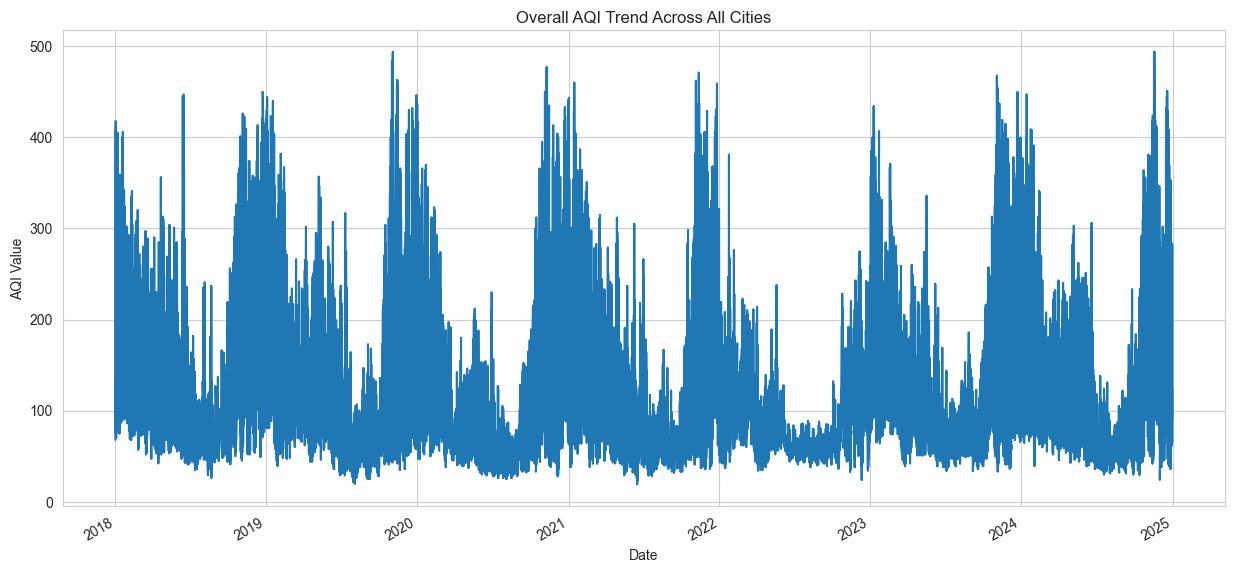

In [7]:
# Cell 2: Set Date as Index and Basic Time Series Plot

# Set the 'Date' column as the DataFrame index
if 'Date' in df_master.columns:
     print("Setting 'Date' column as index.")
     # Check if 'Date' is already the index from a previous run maybe
     if df_master.index.name != 'Date':
          df_master.set_index('Date', inplace=True)
     # Sort the index to ensure chronological order for plots
     df_master.sort_index(inplace=True)
     print("Index set to 'Date' and sorted.")
elif df_master.index.name == 'Date':
     # If already index, just make sure it's sorted
     print("'Date' is already the index. Ensuring it's sorted.")
     df_master.sort_index(inplace=True)
else:
     # Should not happen now that Cell 1 is fixed, but good check
     print("Warning: 'Date' column not found and not index, cannot set index.")

# --- Visualization Setup ---
sns.set_style("whitegrid") # Apply a visual style
plt.rcParams['figure.figsize'] = (15, 7) # Set default plot size

# --- Plot Overall AQI Trend ---
# Check if AQI column exists before plotting
if 'AQI' in df_master.columns:
    print("\nPlotting overall AQI trend...")
    try:
        df_master['AQI'].plot(title='Overall AQI Trend Across All Cities')
        plt.ylabel('AQI Value')
        plt.xlabel('Date') # Label the x-axis
        plt.show() # Display the plot
    except Exception as e:
        # Catch potential plotting errors
        print(f"Error plotting overall AQI: {e}")
else:
    print("Warning: 'AQI' column not found, cannot plot overall trend.")


Plotting AQI trend for each city...


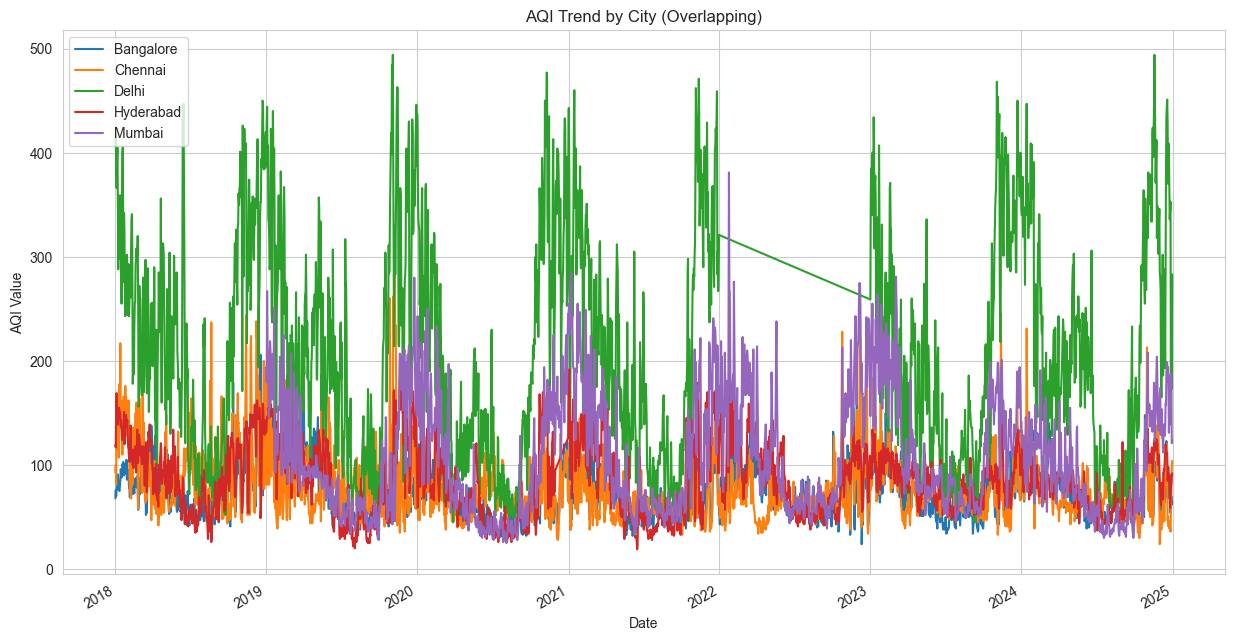


Plotting AQI trend for each city (faceted)...


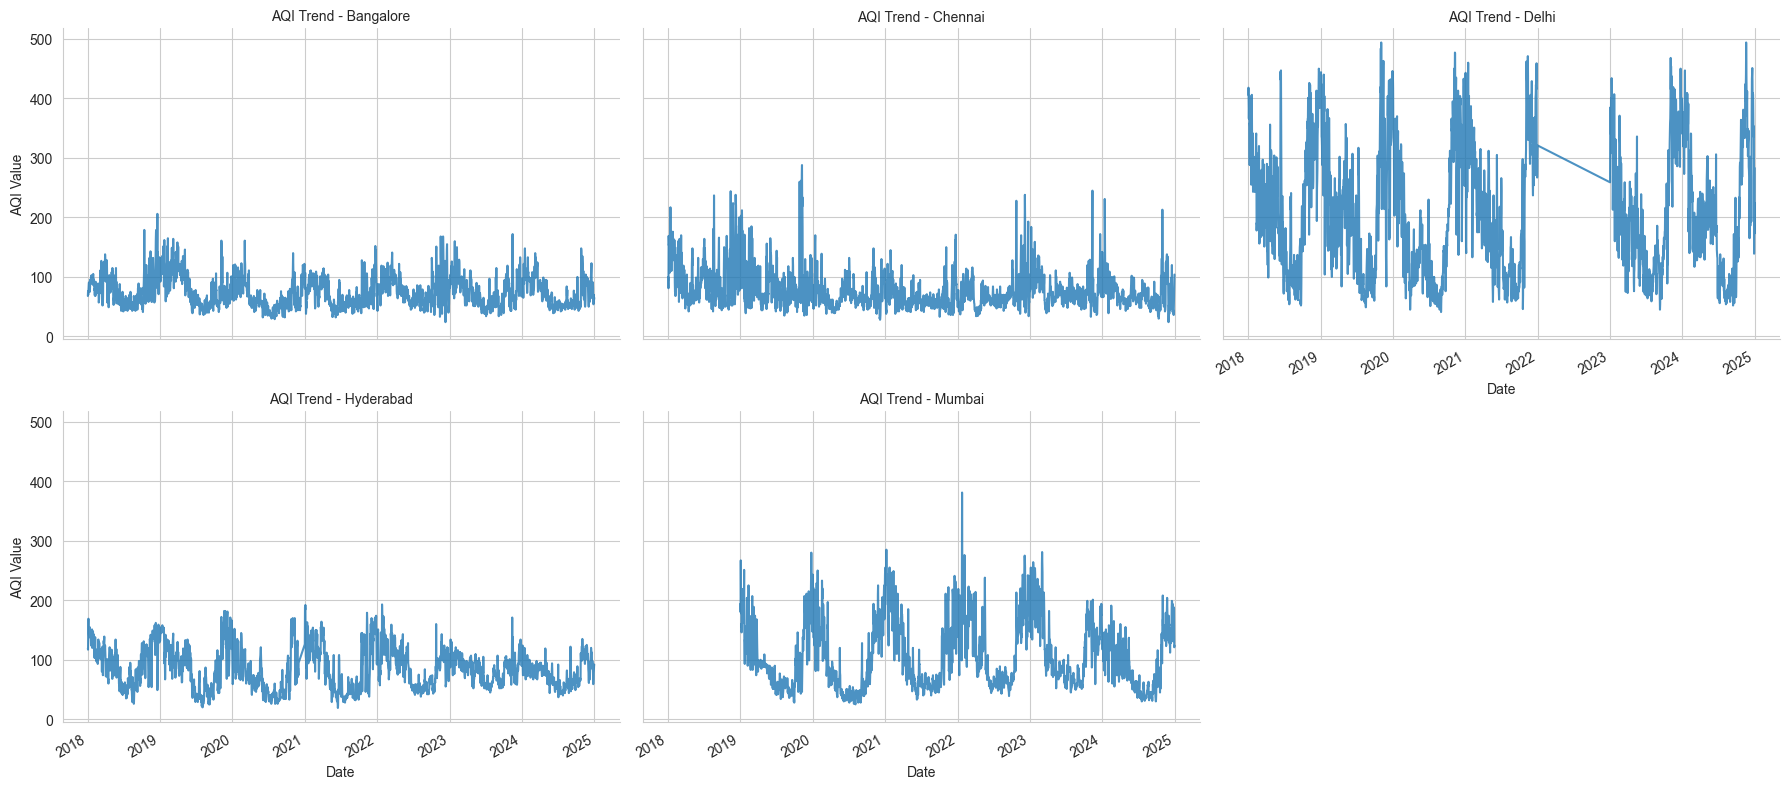

In [8]:
# Cell 3: AQI Trends per City

# Check if required columns ('AQI', 'City') exist
if 'AQI' in df_master.columns and 'City' in df_master.columns:
    print("\nPlotting AQI trend for each city...")
    # Get unique city names from the reconstructed 'City' column
    cities = df_master['City'].unique()
    # Filter out 'Unknown' city if it occurred (shouldn't if data is clean)
    cities = [city for city in cities if city != 'Unknown']

    # --- Overlapping Plot ---
    plt.figure(figsize=(15, 8)) # Create a new figure
    for city in sorted(cities): # Plot cities in alphabetical order
        try:
            city_data = df_master[df_master['City'] == city]
            # Ensure the index is suitable for plotting (datetime)
            if pd.api.types.is_datetime64_any_dtype(city_data.index):
                 city_data['AQI'].plot(label=city) # Plot AQI for the city
            else:
                 print(f"Warning: Index is not datetime for {city}, skipping overlapping plot.")
        except Exception as e:
             print(f"Error plotting overlapping trend for {city}: {e}")

    plt.title('AQI Trend by City (Overlapping)')
    plt.ylabel('AQI Value')
    plt.xlabel('Date')
    plt.legend() # Add legend to identify cities
    plt.show()

    # --- Faceted Plot (Separate plot per city) ---
    print("\nPlotting AQI trend for each city (faceted)...")
    try:
        # FacetGrid often prefers data in 'long format' with Date as a column
        df_plot = df_master.reset_index()
        # Check necessary columns exist in the reset dataframe
        if 'Date' in df_plot.columns and pd.api.types.is_datetime64_any_dtype(df_plot['Date']) and 'City' in df_plot.columns and 'AQI' in df_plot.columns:
             # Create the grid, wrapping after 3 columns
             g = sns.FacetGrid(df_plot[df_plot['City'].isin(cities)], col='City', col_wrap=3, height=4, aspect=1.5, sharey=True, col_order=sorted(cities)) # sharey=True keeps y-axis same for comparison
             # Map the line plot onto the grid
             g.map(sns.lineplot, 'Date', 'AQI', alpha=0.8)
             g.set_titles("AQI Trend - {col_name}") # Set titles for each subplot
             g.set_axis_labels("Date", "AQI Value") # Set axis labels
             # Optional: Improve date label rotation for readability
             for ax in g.axes.flat:
                 if ax: # Check if axis exists (useful if grid isn't full)
                     plt.setp(ax.get_xticklabels(), rotation=30, ha='right')
             plt.tight_layout() # Adjust spacing
             plt.show()
        else:
             print("Warning: Could not prepare data correctly for faceted plot (Date, City, or AQI column missing/invalid after reset_index).")
    except Exception as e:
        print(f"Error creating faceted plot: {e}")

else:
    # This message appears if 'AQI' or 'City' wasn't found/created in Cell 1
    print("Warning: 'AQI' or 'City' column not found, cannot plot trends per city.")


Analyzing AQI distribution per city...
Error creating box plot: cannot reindex on an axis with duplicate labels

Plotting AQI distribution for each city (histogram/density)...


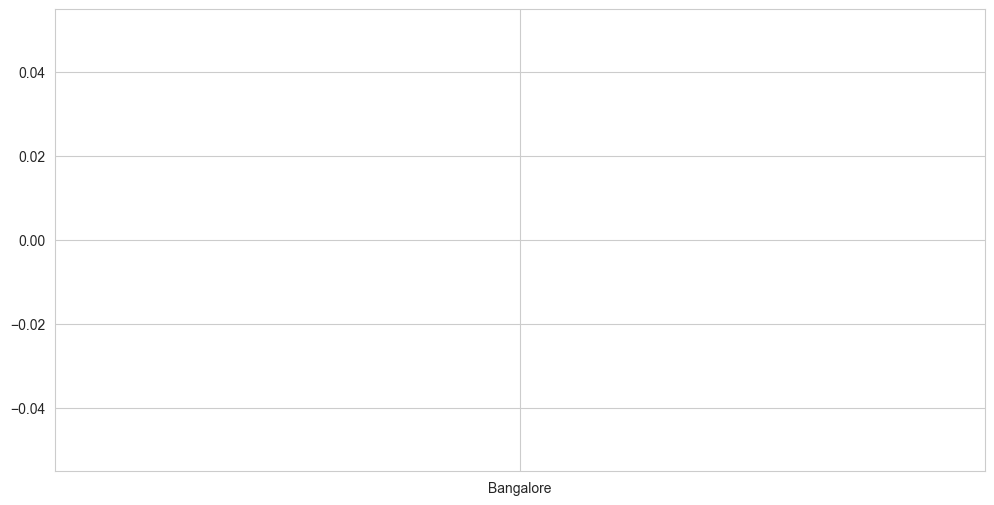

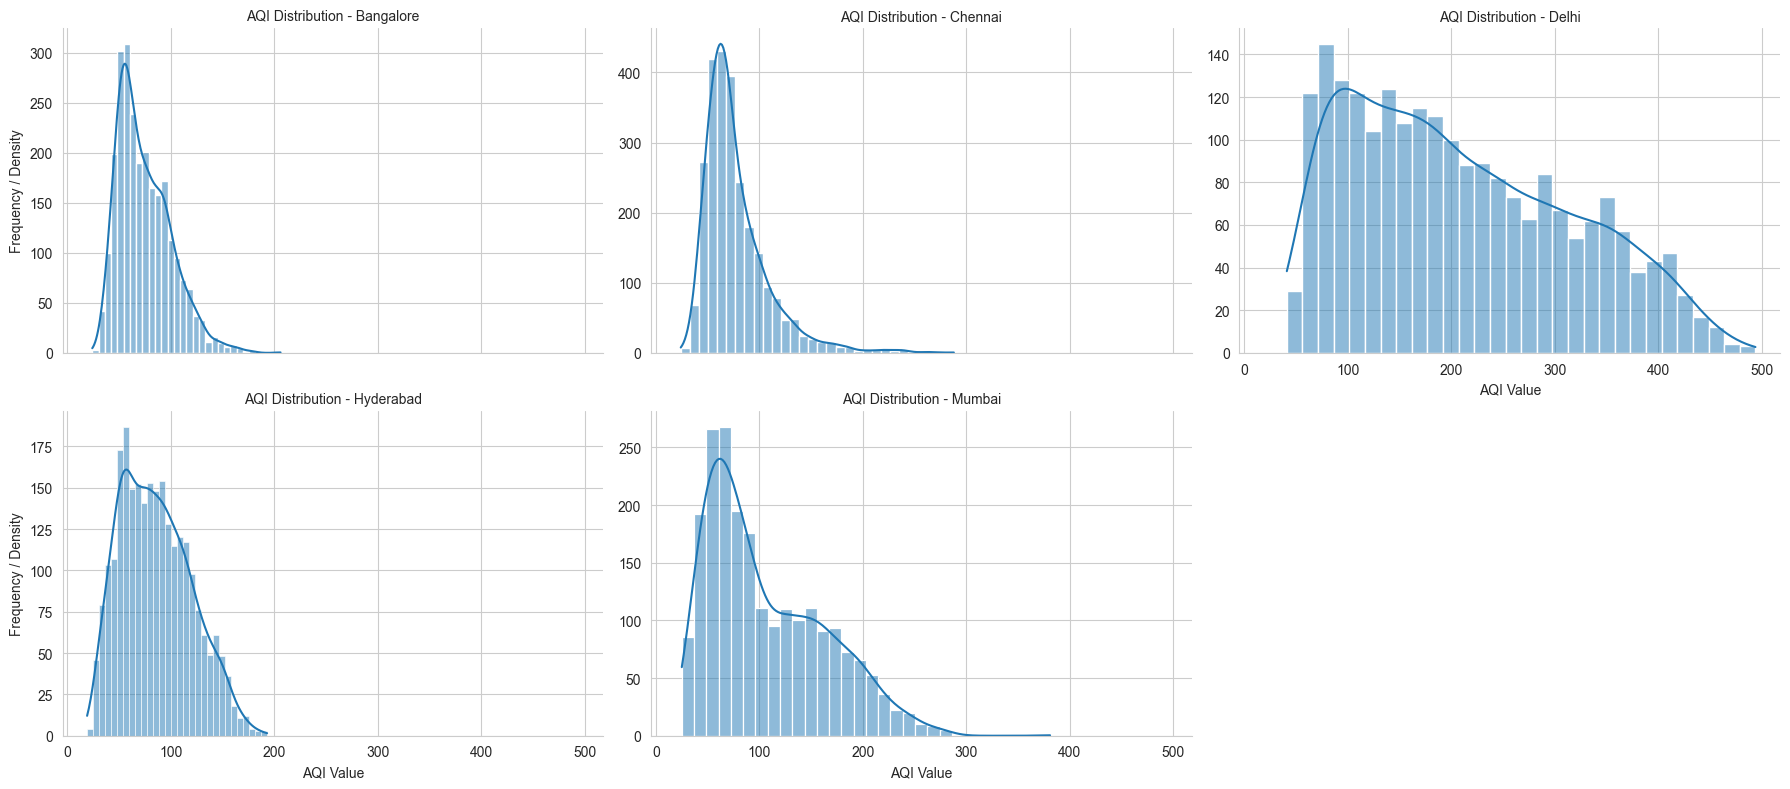

In [9]:
# Cell 4: AQI Distribution Analysis

# Check if required columns exist
if 'AQI' in df_master.columns and 'City' in df_master.columns:
    print("\nAnalyzing AQI distribution per city...")
    # Get unique valid city names
    cities = df_master['City'].unique()
    cities = [city for city in cities if city != 'Unknown']
    # Create a dataframe filtered to only include valid cities for plotting
    df_plot_dist = df_master[df_master['City'].isin(cities)]

    # --- Box Plot ---
    try:
        plt.figure(figsize=(12, 6))
        # Create boxplot, order cities alphabetically
        sns.boxplot(x='City', y='AQI', data=df_plot_dist, order=sorted(cities))
        plt.title('Distribution of AQI Values by City (Box Plot)')
        plt.ylabel('AQI Value')
        plt.xlabel('City')
        plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for readability
        plt.tight_layout() # Adjust layout
        plt.show()
    except Exception as e:
        print(f"Error creating box plot: {e}")


    # --- Histogram / Density Plot (Faceted) ---
    print("\nPlotting AQI distribution for each city (histogram/density)...")
    try:
        # Create facet grid, order columns alphabetically
        g = sns.FacetGrid(df_plot_dist, col='City', col_wrap=3, height=4, aspect=1.5, sharey=False, col_order=sorted(cities)) # sharey=False allows different y-axes for better view of each distribution's shape
        # Map histogram with Kernel Density Estimate overlay
        g.map(sns.histplot, 'AQI', kde=True, bins=30) # Adjust 'bins' if needed
        g.set_titles("AQI Distribution - {col_name}")
        g.set_axis_labels("AQI Value", "Frequency / Density")
        plt.tight_layout() # Adjust spacing
        plt.show()
    except Exception as e:
        print(f"Error creating distribution plots: {e}")

else:
    # This message appears if 'AQI' or 'City' wasn't found/created in Cell 1
    print("Warning: 'AQI' or 'City' column not found, cannot analyze distributions.")